<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 7th exercise: <font color="#C70039">Autoregressive Moving Average model - ARMA(p,q): Bandwidth Usage Forecast</font>
* Course: <a href="https://www.gernotheisenberg.de/time_series_forecasting.html">Time Series Forecasting (TSF)</a>
* Lecturer: <a href="https://www.gernotheisenberg.de/uebermich.html">Gernot Heisenberg</a>
* Date:   11.03.2025

<img src="./images/ARMA.jpg" style="float: center;" width="450">

---------------------------------
**GENERAL NOTE 1**:
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole.

**GENERAL NOTE 2**:
* Please, when commenting source code, just use English language only.
* When describing an observation please use English language, too
* This applies to all exercises throughout this course.  

---------------------

### <font color="ce33ff">DESCRIPTION OF THE NOTEBOOK CONTENT</font>:
This notebook allows you for learning how to implement and apply another statistical model, an Autoregressive moving average model of orders p and q ARMA(p,q).

-------------------------------------------------------------------------------------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points.
If a task is more challenging and consists of several steps, this is indicated as well.
Make sure you have worked down the task list and commented your doings.
This should be done by using markdown.<br>
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date.
    * set the date too and remove mine.
3. read the entire notebook carefully
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time.
    * understand the output
4. Create a simulated ARMA(1,1) process and make predictions
    * Simulate an ARMA(1,1) process, split it into train and test sets
    * Assign 80% of the data to the train set and the remaining 20% to the test set
    * Use the rolling_forecast function to make predictions using the ARMA(1,1) model, the mean method, and the last known value method
    * Plot your forecasts
    * Evaluate each method’s performance using the MSE. Which method performed best?
-----------------------------------------------------------------------------------

## 7.0 Module import

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
#from tqdm import tqdm_notebook
from tqdm.notebook import tqdm
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# SECTION I (artificial case for better understanding the analysis process)
## 7.1 Identifying a stationary ARMA process

In this section, we simulate a stationary ARMA process and check for stationarity using the Augmented Dickey-Fuller (ADF) test.

In [2]:
# set random seed for reproducability
np.random.seed(42)

# generate a sample of 1000 data points from the ARMA(1,1) process
ar1 = np.array([1, -0.33])
ma1 = np.array([1, 0.9])

ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

In [3]:
# perform ADF test
ADF_result = adfuller(ARMA_1_1)

# display results
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -6.42987868204269
p-value: 1.7078466680096923e-08


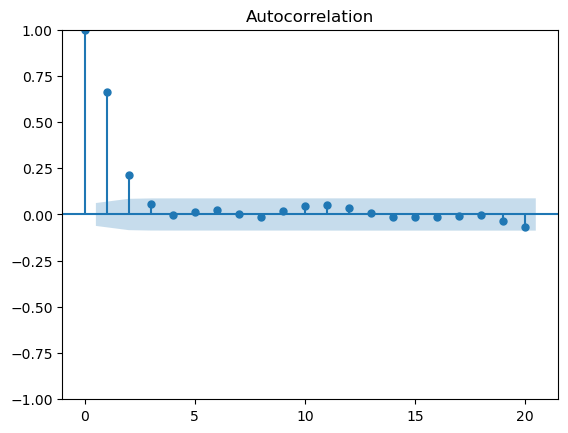

In [4]:
plot_acf(ARMA_1_1, lags=20);

In ACF you will notice a sinusoidal pattern in the plot, which indicates the presence of an autoregressive process. This is expected, since we simulated an ARMA(1,1) process and we know of the existence of the autoregressive portion.<br>
Furthermore, you’ll notice that the last significant coefficient is at lag 2. However, we know that our simulated data has an MA(1) process, so we would expect to have significant coefficients up to lag 1 only. We can thus conclude that the ACF plot does not reveal any useful information about the order q of our ARMA(1,1) process.

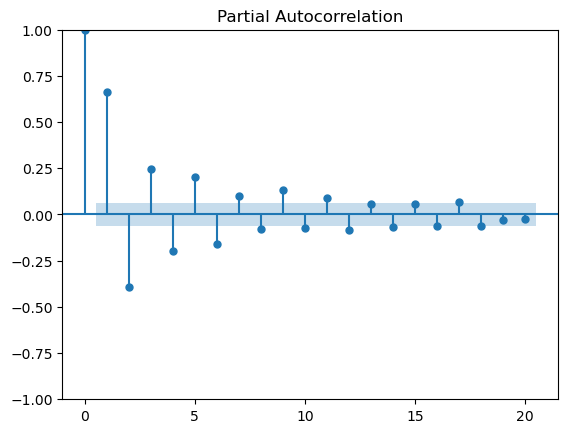

In [5]:
plot_pacf(ARMA_1_1, lags=20);

In this PACF figure we can see a clear sinusoidal pattern, meaning that we cannot infer a value for the order p. We know that we simulated an ARMA(1,1) process, but we cannot
determine that value from the PACF plot above, since we have significant coefficients past lag 1.<br>
Therefore, the PACF plot cannot be used to find the order p of an ARMA(p,q) process.

#### <font color=red>SUMMARY</font>
We know that our process is stationary and we can see that the ACF as well as the PACF plots show a decaying and/or sinusoidal pattern. This is the indication for having a stationary ARMA(p,q) process at hand.

## 7.2 Optimizing the ARMA model

We define a function optimize_ARMA that searches through different ARMA model orders and selects the best one based on the Akaike Information Criterion (AIC).

In [6]:
# define possible p and q values for ARMA model orders
ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))
print(order_list)

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]


In [7]:
from typing import Union

# define a function to optimize ARMA model orders using AIC
def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:

    results = []

    for order in tqdm(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sort in ascending order since the lower the AIC, the better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [8]:
result_df = optimize_ARMA(ARMA_1_1, order_list)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(1, 1)",2801.407785
1,"(2, 1)",2802.906070
2,"(1, 2)",2802.967762
3,"(0, 3)",2803.666793
4,"(1, 3)",2804.524027
5,"(3, 1)",2804.588567
6,"(2, 2)",2804.822282
7,"(3, 3)",2806.068068
8,"(2, 3)",2806.175380
9,"(3, 2)",2806.894930


## 7.3 Residual analysis

We generate Q-Q plots to visually inspect whether the resulting residuals follow a normal distribution. Then we fit an ARMA model on the generated ARMA data and analyze the residuals using diagnostic plots and the Ljung-Box test.

### Qualitative analysis: studying the Q-Q plot

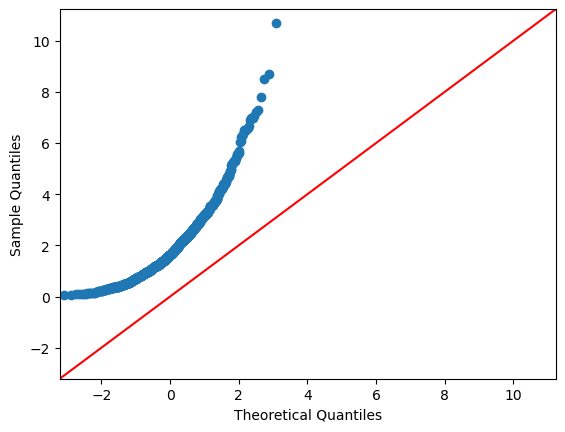

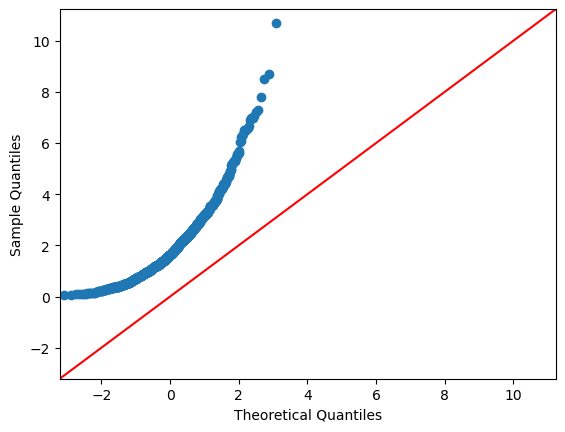

In [11]:
from statsmodels.graphics.gofplots import qqplot

gamma = np.random.default_rng().standard_gamma(shape=2, size=1000)
qqplot(gamma, line='45')

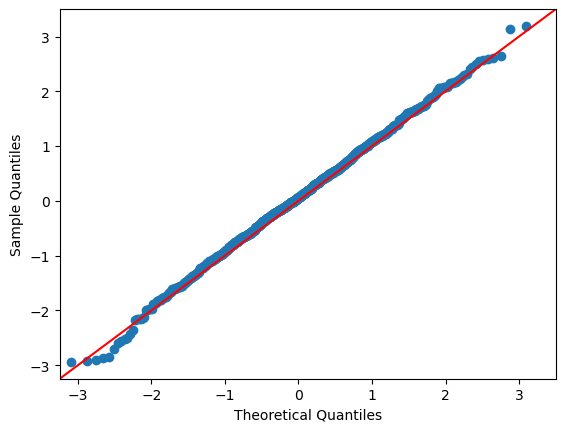

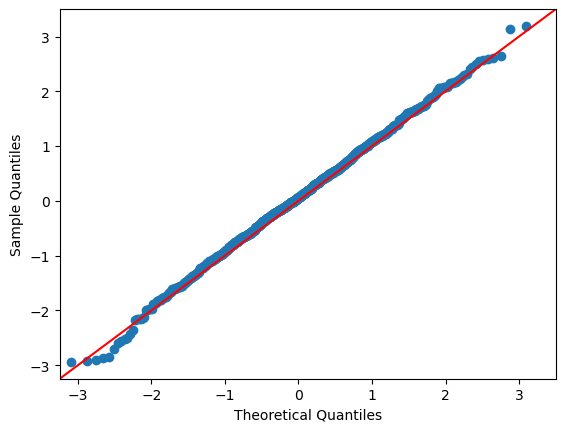

In [12]:
normal = np.random.normal(size=1000)
qqplot(normal, line='45')

### Performing residuals analysis

In [13]:
model = SARIMAX(ARMA_1_1, order=(1,0,1), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid

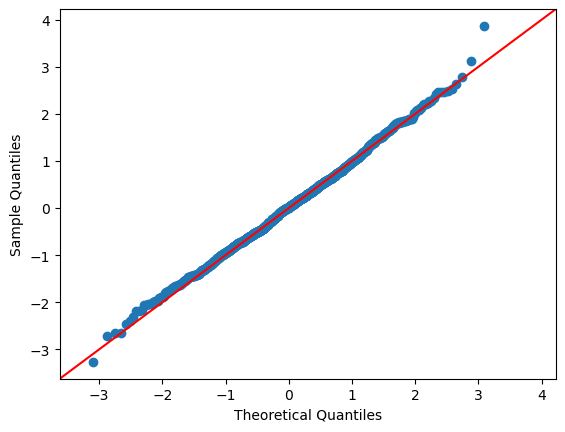

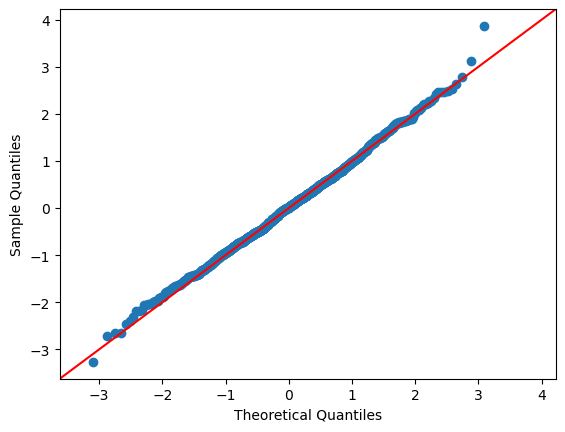

In [14]:
from statsmodels.graphics.gofplots import qqplot

qqplot(residuals, line='45')

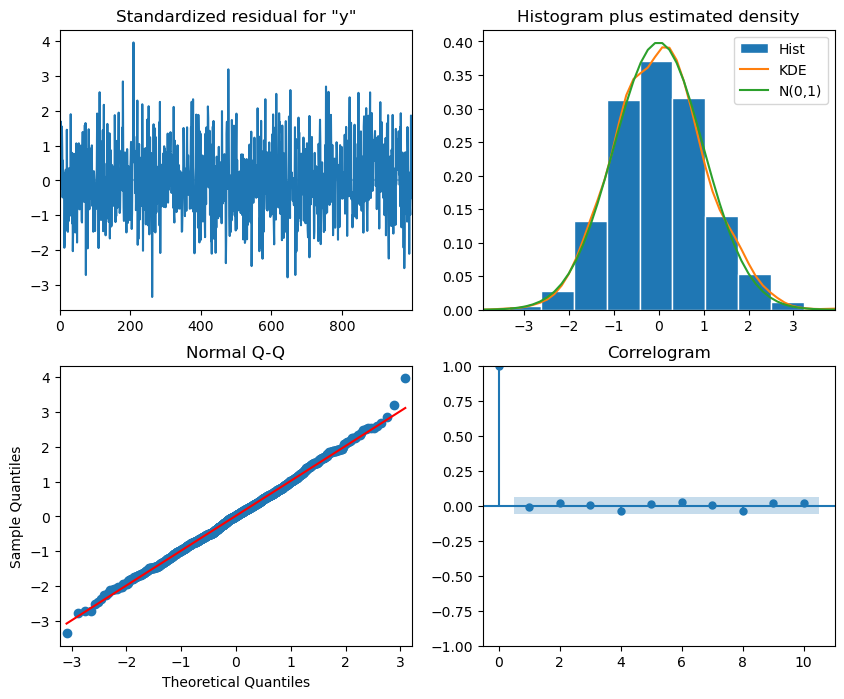

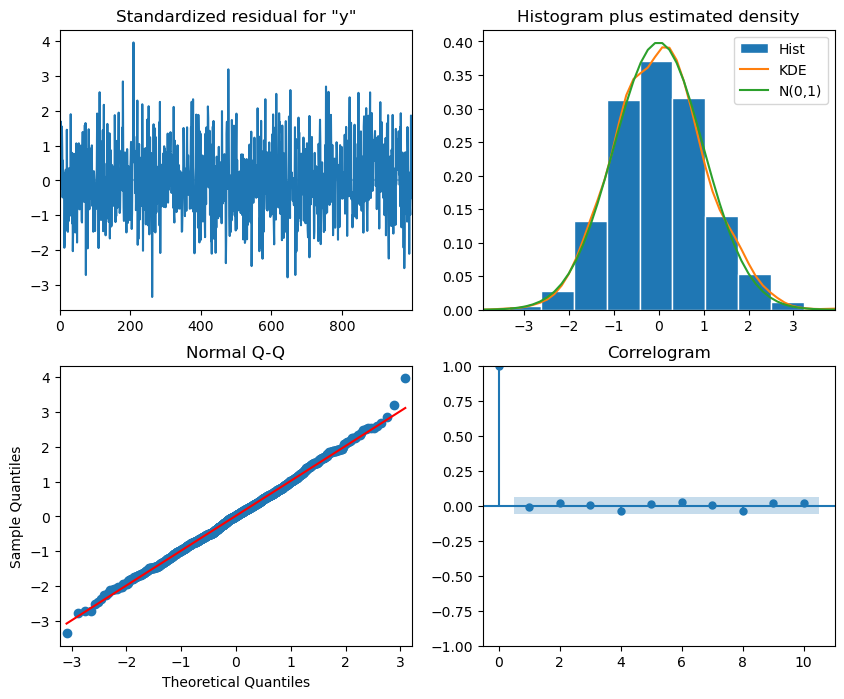

In [15]:
model_fit.plot_diagnostics(figsize=(10, 8))

In the upper right plot you can see a KDE (Kernel Density Estimate) labeled line. 
It is a smoothed representation of your data distribution. It estimates the probability density function (PDF) of the residuals. 
Essentially, KDE smooths out the histogram, making it easier to see the underlying shape of the data.

<font color=red>How to interpret the KDE line:</font>

* Bell-shaped and symmetrical KDE curve: Good sign! This indicates that your residuals resemble a normal distribution.
* Skewed KDE curve (asymmetric or heavy tails): This indicates residuals deviate from normality. Your model may have unexplained patterns, outliers, or may require a different modeling approach.
* Multiple peaks or irregular shapes: This indicates the residuals might have complex, unexplained patterns.


In [17]:
# perform Ljung-Box test on residuals to check for autocorrelation
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_value = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(lb_value)

     lb_stat  lb_pvalue
1   0.030706   0.860897
2   0.528021   0.767966
3   0.540904   0.909817
4   2.079774   0.721089
5   2.271897   0.810385
6   2.896262   0.821750
7   2.900378   0.894063
8   4.418799   0.817501
9   4.787567   0.852419
10  5.246805   0.874093


# SECTION II (use case)
## 7.4 Model preparation

Start the model preparation in the usual manner and apply the ADF test.

In [18]:
# load data
import pandas as pd


df = pd.read_csv('./data/bandwidth.csv')

df.head()

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816


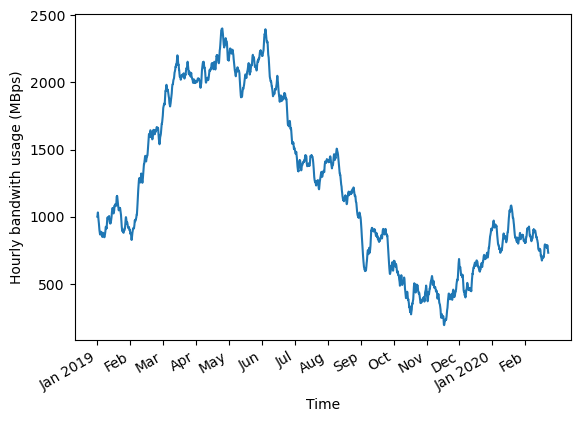

In [19]:
# plot the bandwidth usage over time
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(df['hourly_bandwidth'])
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')

plt.xticks(
    np.arange(0, 10000, 730),
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])

fig.autofmt_xdate()

In [20]:
# performn ADF test
ADF_result = adfuller(df['hourly_bandwidth'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -0.8714653199452924
p-value: 0.7972240255014491


In [21]:
bandwidth_diff = np.diff(df.hourly_bandwidth, n=1)

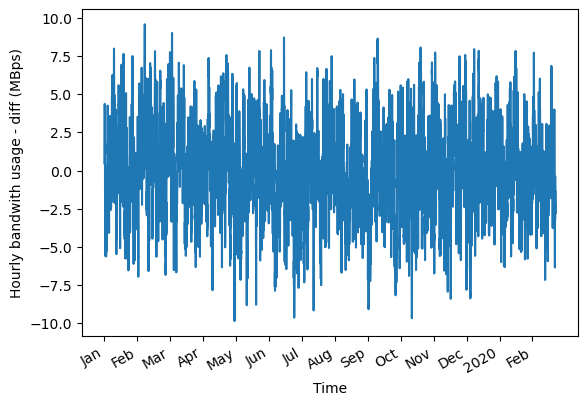

In [22]:
# plot the differenced data
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(bandwidth_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage - diff (MBps)')

plt.xticks(
    np.arange(0, 10000, 730),
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])

fig.autofmt_xdate()

In [23]:
# perform ADF test on differrenced data
ADF_result = adfuller(bandwidth_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -20.694853863789014
p-value: 0.0


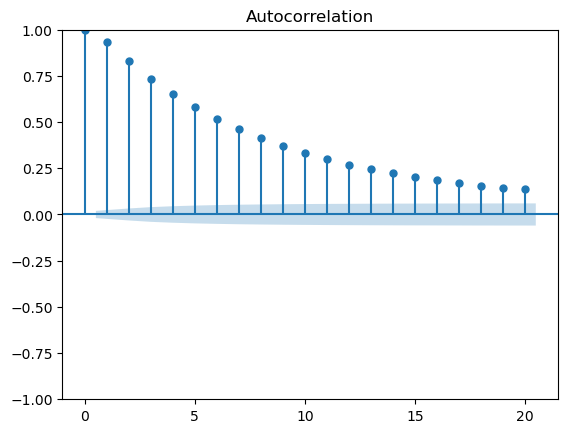

In [24]:
plot_acf(bandwidth_diff, lags=20);

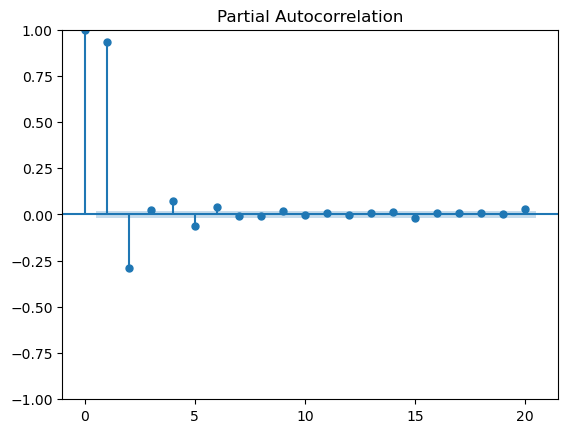

In [25]:
plot_pacf(bandwidth_diff, lags=20);

## 7.5 Model building and training

We can now establish a model to foracast the bandwith usage and train it with the given data.

In [26]:
df_diff = pd.DataFrame({'bandwidth_diff': bandwidth_diff})

train = df_diff[:-168]
test = df_diff[-168:]

print(len(train))
print(len(test))

9831
168


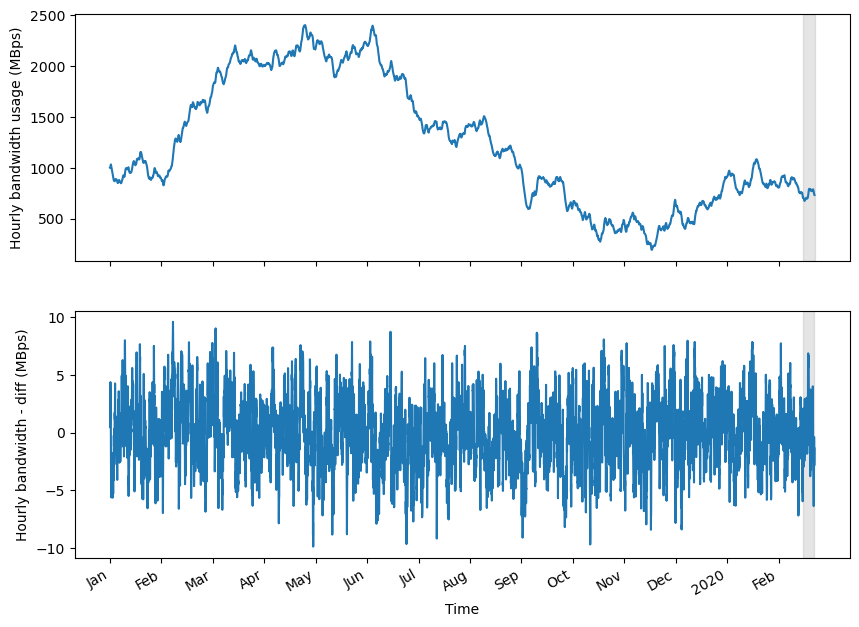

In [27]:
# visualize data
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

ax1.plot(df['hourly_bandwidth'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Hourly bandwidth usage (MBps)')
ax1.axvspan(9831, 10000, color='#808080', alpha=0.2)

ax2.plot(df_diff['bandwidth_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Hourly bandwidth - diff (MBps)')
ax2.axvspan(9830, 9999, color='#808080', alpha=0.2)

plt.xticks(
    np.arange(0, 10000, 730),
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])

fig.autofmt_xdate()

In [28]:
from typing import Union

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:

    results = []

    for order in tqdm(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [29]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))

In [30]:
result_df = optimize_ARMA(train['bandwidth_diff'], order_list)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 2)",27991.063879
1,"(2, 3)",27991.287509
2,"(2, 2)",27991.603598
3,"(3, 3)",27993.416924
4,"(1, 3)",28003.349550
5,"(1, 2)",28051.351401
6,"(3, 1)",28071.155496
7,"(3, 0)",28095.618186
8,"(2, 1)",28097.250766
9,"(2, 0)",28098.407664


In [31]:
# fit the model and investigate results
model = SARIMAX(train['bandwidth_diff'], order=(2,0,2), simple_differencing=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         bandwidth_diff   No. Observations:                 9831
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -13990.802
Date:                Tue, 11 Mar 2025   AIC                          27991.604
Time:                        21:30:46   BIC                          28027.570
Sample:                             0   HQIC                         28003.788
                               - 9831                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3486      0.052      6.765      0.000       0.248       0.450
ar.L2          0.4743      0.047     10.000      0.000       0.381       0.567
ma.L1          0.8667      0.050     17.249      0.0

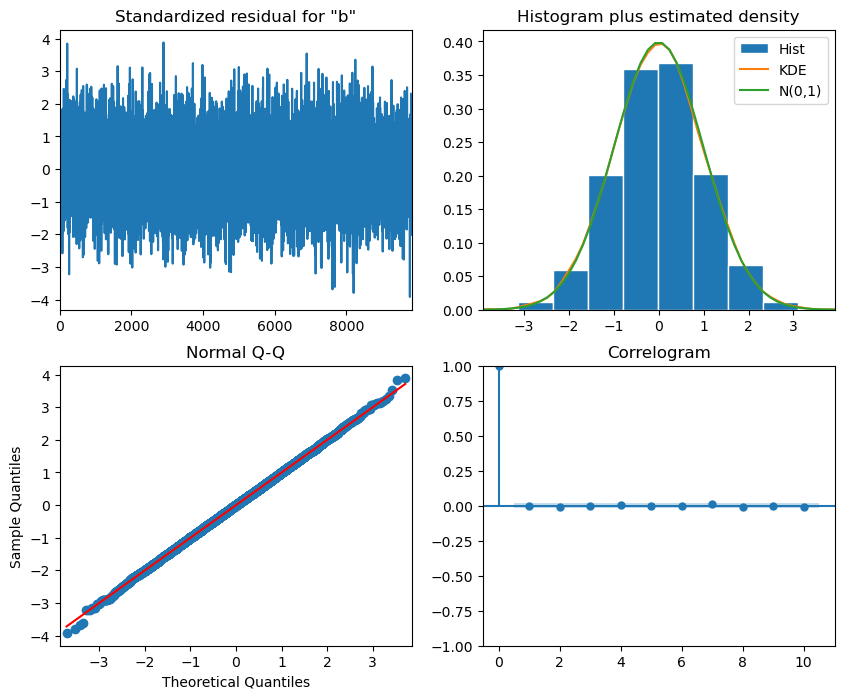

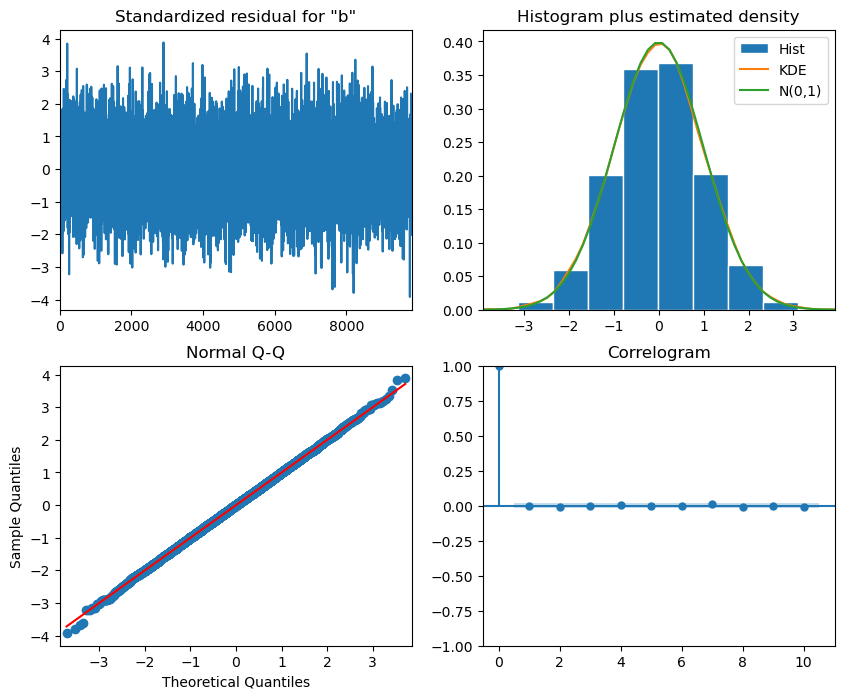

In [32]:
model_fit.plot_diagnostics(figsize=(10, 8))

In [33]:
residuals = model_fit.resid

lb_value = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(lb_value)

     lb_stat  lb_pvalue
1   0.042190   0.837257
2   0.418364   0.811247
3   0.520271   0.914416
4   0.850555   0.931545
5   0.850841   0.973678
6   1.111754   0.981019
7   2.124864   0.952607
8   3.230558   0.919067
9   3.248662   0.953615
10  3.588289   0.964015


## 7.6 Forecasting bandwidth usage

Use the established model to forecast the bandwidth usage.

In [34]:
# define forecasting function
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon
    end_idx = train_len

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'ARMA':
        pred_ARMA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)

        return pred_ARMA

In [35]:
# generate forecast

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA

test.head()

,bandwidth_diff,pred_mean,pred_last_value,pred_ARMA
9831,-5.943995,-0.028214,-5.791207,-5.460661
9832,-5.865194,-0.028214,-5.791207,-4.890626
9833,-3.197066,-0.029410,-5.865194,-5.335905
9834,-1.090197,-0.029410,-5.865194,-4.751731
9835,0.665291,-0.029840,-1.090197,-0.375596


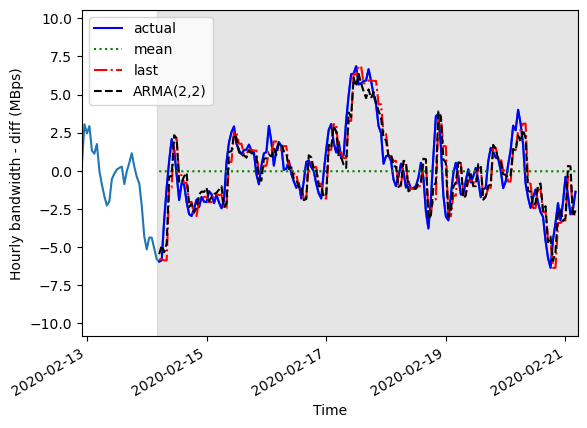

In [36]:
#plot forecast
fig, ax = plt.subplots()

ax.plot(df_diff['bandwidth_diff'])
ax.plot(test['bandwidth_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_ARMA'], 'k--', label='ARMA(2,2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth - diff (MBps)')

ax.axvspan(9830, 9999, color='#808080', alpha=0.2)

ax.set_xlim(9800, 9999)

plt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])

fig.autofmt_xdate()

In [37]:
mse_mean = mean_squared_error(test['bandwidth_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['bandwidth_diff'], test['pred_last_value'])
mse_ARMA = mean_squared_error(test['bandwidth_diff'], test['pred_ARMA'])

print(mse_mean, mse_last, mse_ARMA)

6.306526957989325 2.2297582947733656 1.769046211330053


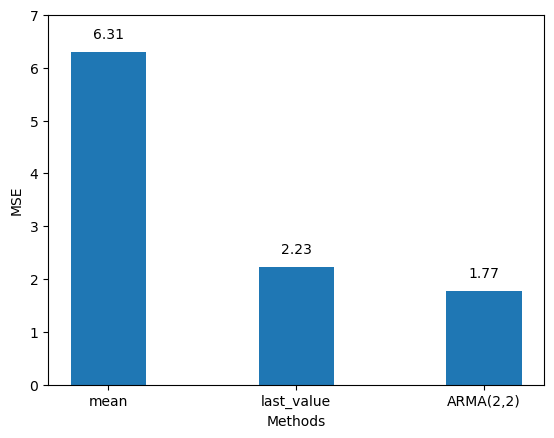

In [38]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'ARMA(2,2)']
y = [mse_mean, mse_last, mse_ARMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 7)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

#### Reverse the differencing to get actual predictions for the original series and visualize it.

In [39]:
df['pred_bandwidth'] = pd.Series()
df['pred_bandwidth'][9832:] = df['hourly_bandwidth'].iloc[9832] + test['pred_ARMA'].cumsum()

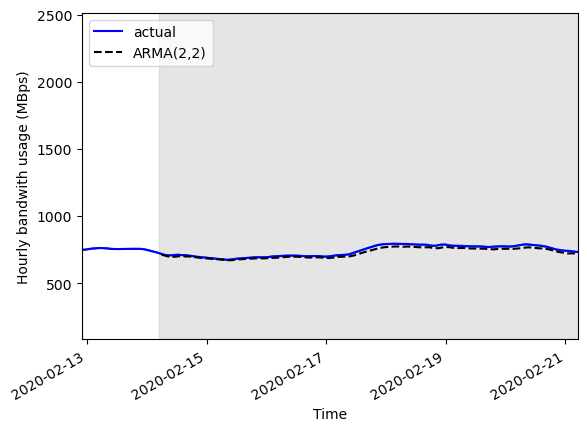

In [40]:
fig, ax = plt.subplots()

ax.plot(df['hourly_bandwidth'])
ax.plot(df['hourly_bandwidth'], 'b-', label='actual')
ax.plot(df['pred_bandwidth'], 'k--', label='ARMA(2,2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')

ax.axvspan(9831, 10000, color='#808080', alpha=0.2)

ax.set_xlim(9800, 9999)

plt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])

fig.autofmt_xdate()

In [41]:
mae_ARMA_undiff = mean_absolute_error(df['hourly_bandwidth'][9832:], df['pred_bandwidth'][9832:])

print(mae_ARMA_undiff)

14.00036277643387
